## Spam Filtering in YouTube Video comments using NLP Techniques

In this kernel we will use various machine learning models to see which performs the best for the comments on each of the videos. I have implemented the solution based on the research paper [TubeSpam: Comment Spam Filtering on YouTube](http://www.dt.fee.unicamp.br/~tiago//papers/TCA_ICMLA15.pdf) where each file was considered as a single dataset and the performance of classifiers on each was optimized and compared. 

I have used the following models for comparison:
1.  Logistic Regression Classifier
1.  Naive - Bayes Classifier
1.  Suppot Vector Classifer
1.  K Neighbors Classifier
1.  Decision Tree Classifier
1.  Random Forest Classifier
1.  XGBoost Classifier

#### Steps:
The steps involved are divided into two parts: 

1) Data pre-processing using NLP techniques 

2) Applying Machine Learning on the processed data

#### Data Pre-processing/NLP

We create helper functions to do most of the steps below:

1) Reading the CSV file and Converting into TSV 
    - To accomodate dataset with comma within comments
    - TSV is better document type for this problem as its tab separated 
2) Cleaning the data
    - Remove all charaters except alphabets a-z & A-Z
    - Convert everything to lower keys
    - Split each comment row into list of words
    - Apply Stemming - From Wiki (https://en.wikipedia.org/wiki/Stemming), stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root. 
    - Joining all the words back to a list of words called Corpus. Corpus is a large collection of texts. It is a body of written or spoken material upon which a linguistic analysis is based. Read more about Corpus [here](http://language.worldofcomputing.net/linguistics/introduction/what-is-corpus.html)
3) Creating the Bag of Words model
    - The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms. 
    - It is used for feature extraction in natural language processing
    - What we get is a sparse matrix with each unique words in the Corpus as column headers and frequency of each of those words in corresponding rows(comments) of dataset as cell values
4) Splitting the dataset (bag of words model) into train and test set

5) Optimization:  Finding the best configurations for all Classifier models, for each dataset using GridSearchCV

6) Fitting each classifier to our dataset and predicting the test result

7) Evaluation: Comparing the selected metrics across all classifiers to find the best classifier for each dataset

#### Evaluation Metrics

For evaluating Youtube Comment Spam Filtering model, Accuracy, Spam Catch Rate, Blocked Ham Rate and Matthews Coefficient have been used, to compare between classifier models. A Blocked ham(non-spam email) is more expensive than a non-caught spam (spam email), hence a balance between spam caught rate and blocked ham is required to better evaluate the model. 
Formulas for the metrics are as follows:
1. Accuracy : (TP+TN)/(TP+TN+FP+FN)
1. Spam Caught Rate: TP/ (TP+FP)
1. Blocked Ham Rate: TN / (TN + FN)
1. Matthews Coefficient: : A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

We will also plot the ROC curve to better understand the choice of classifier. AUC-ROC curve tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,csv,os
import seaborn as sns
#NLP libraries
import re
import nltk #importing the tools (list of irrelevant words) which has to be removed
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Text Processing
from sklearn.feature_extraction.text import CountVectorizer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, cross_validate, RandomizedSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report, make_scorer, fbeta_score, matthews_corrcoef

# Visualization
from matplotlib.pyplot import cm
from funcsigs import signature
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import warnings
warnings.filterwarnings('ignore')



#### Initializing list of Classifier dictionaries

In [2]:
# Classifier Details
classifiers = [
{
    'label': 'Logistic Regression Classifier',
    'model': LogisticRegression(),
    'parameters': {"penalty": ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 10]},
    'g_cv' : 10
    
},
{
    'label': 'Naive- Bayes Classifier',
    'model': GaussianNB(),
    'parameters': {},
    'g_cv' : 10
    
},
{
    'label': 'Support Vector Classifier',
    'model': SVC(),
    'parameters': {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
    'g_cv' : 10
},
{
    'label': 'K-Nearest Neighbor',
    'model': KNeighborsClassifier(),
    'parameters':{"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
    'g_cv' : 10
},
{
    'label': 'Decision Tree Classifier',
    'model': DecisionTreeClassifier(),
    'parameters': {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))},
    'g_cv' : 10
    
},
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(),
    'parameters': { 'n_estimators': [10,100,300,500],
                   "criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))},
    'g_cv' : 5    
 },

{
    'label': 'XGBoost Classifier',
    'model': XGBClassifier(),
    'parameters': { 'learning_rate': [0.01], 'n_estimators':[100,500],
                   'gamma': [0.5, 1, 1.5], 'subsample': [0.6, 0.8, 1.0], 
                   'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [2]},
    'g_cv' : 2
    
}
]

###### Function to convert CSV to TSV

In [3]:
def convert_to_tsv(csv_file, tsv_file):
    """
    Converts a comma-separated file to tab_separated file
    
    Args:    
        csv_file: path to csv_file
        tsv_file: path to new tsv_file

    Returns:    
        tsv_file: path to new tsv_file
    
    """           
    csv.writer(open(tsv_file, 
                    'w+',
                    encoding="utf-8"),
    delimiter='\t').writerows(csv.reader(open(csv_file,
                              encoding="utf8")))
    return tsv_file

###### Function to clean the input file and create corpus

In [4]:
def create_corpus(dataset):
    """Creates corpus from the input dataset
    
    Args:
        Dataset: Input data as pandas Dataframe
        
    Returns:
        corpus: List of preprocessed input data
        
    """
    corpus = [] 
    for i in range(0,len(dataset)):
        #remove all characters except a-z, removed charac will be replaced by space
        comment = re.sub(pattern = '[^a-zA-Z]',repl = ' ' , string = dataset['CONTENT'][i]) 
        
        #to lower case
        comment = comment.lower() 
        
        #splitting each  comment sentence into list of words
        comment = comment.split() 
        
        #Stemming 
        ps = PorterStemmer()
        comment = [ps.stem(word) for word in comment if not word in set(stopwords.words('english'))] 
        
        #Joining the words back 
        comment =' '.join(comment)
        corpus.append(comment)
    return corpus

###### Function to create the Bag of Words model from corpus

In [5]:
def bag_of_words(corpus):
    """Creating Bag of Words Model
    
    Creates bag of words using CountVectorizer, which is a sparse matrix
    with all the words from corpus. Each cell will contain its own frequency
    in the corresponding comment.
    
    Args:
        corpus, a list containing processed input dataset
        
    Returns:
        The sparse matrix (bag of words) X and labels y
    
    """   
    # tokenizer
    cv = CountVectorizer()
    X = cv.fit_transform(corpus).toarray() 
    
    # re-initializing to add max_features so that we can filter out irrelevant words which has very less frequency
    cv = CountVectorizer(max_features = (X.shape[1] - 50))
    X = cv.fit_transform(corpus).toarray() 
    y = dataset.iloc[:,-1].values

    return X,y

###### Function to find the optimized Classifiers - Using GridSearchCV

In [6]:
def best_estimator(classifiers, X_train, y_train, filename):
    """Finding the best estimator 
    
    Uses GridSearchCV to search for the best parameters for all
    the classifiers used to find the best optimized classifier
    
    Args: 
        classifiers: List of classifier dictionaries with names and parameter details
                
        X_train: X values of training data
        
        y_train: Actual labels of training data
        
        filename: String
        Name of Youtube accounts whose comments are being classified
        
    Returns:
        best_estimator: Dictionary of classifiers parameters, optimized for each dataset
    
    """
    
    scoring = {'acc': 'accuracy',
               'AUC': 'roc_auc',
              'prec_macro': 'precision_macro',
               'rec_micro': 'recall_micro',
               'f1_score': 'f1_micro'}
    best_estimators = dict()
    best_scores_df = pd.DataFrame()
     
    for c in classifiers:
            classifier = c['model']
            label = c['label']
            print('\n\n Optimized ', label, 'for ', filename)
            print('---------------------------------------')
            
            #print('%s Best Values' % (c['label']))
            grid_search = GridSearchCV(estimator = classifier,
                       param_grid = c['parameters'],
                       scoring = scoring,
                       refit='acc',
                       cv = c['g_cv'],
                       return_train_score=True,
                       verbose =1)
            if label == 'Random Forest Classifier':
                grid_search.fit(X_train, y_train, sample_weight = None)
            else:
                grid_search.fit(X_train, y_train)
            results = grid_search.cv_results_
            print('\n')
            #print('Best Accuracy Score: ',round(grid_search.best_score_*100,2),'%')
            print('Best Parameters: ',grid_search.best_params_)
            
            best_estimators[label] = grid_search.best_estimator_
            
            data = [[label, round(grid_search.best_score_*100,2)]]
            df2 = pd.DataFrame(data, columns = ['Classifier','Accuracy']) 
            best_scores_df = best_scores_df.append(df2)
            
            #best_scores[label] = round(grid_search.best_score_*100,2)
            
            print('\n')
            for key,scorer in scoring.items():
                #print('{} scores:\n '.format(scorer))
                for sample in ('train','test'):
                    sample_score_mean = round(results['mean_%s_%s' % (sample, key)].mean()*100,2)
                    sample_score_std = round(results['std_%s_%s' % (sample, key)].mean()*100,2)
                    if(sample == 'train'):
                        to_print = 'Training'
                    else:
                        to_print = 'Validation'
                    print(to_print,' ',scorer,' : ',sample_score_mean, '% (+/-)', sample_score_std,'%')
                print('\n')
                   
            print('-----------------------------------------')
                
    print('Comparing the Best Cross-Validated Accuracy between Classifiers')
    best_scores_df
    #print('\t'.join(['{0}{1} % \n'.format(k, v) for k,v in best_scores.items()]))
    return best_estimators

###### Function to Plot Learning Curve

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
                     
    """Generate a simple plot of the test and training learning curve.
    
    Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    Args:
        estimator: object type that implements the "fit" and "predict" methods
            An object of that type which is cloned for each validation.

        title: string
            Title for the chart.

        X: array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y: array-like, shape (n_samples) or (n_samples, n_features), optional
            Target relative to X for classification or regression;
            None for unsupervised learning.

        ylim: tuple, shape (ymin, ymax), optional
            Defines minimum and maximum yvalues plotted.

        cv: int, cross-validation generator or an iterable, optional
            Determines the cross-validation splitting strategy.

        n_jobs: int or None, optional (default=None)
            Number of jobs to run in parallel.
           
        train_sizes: array-like, shape (n_ticks,), dtype float or int
            Relative or absolute numbers of training examples that will be used to
            generate the learning curve. 
            
    Returns:
        plt: an object of the generated plot
    
    """

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

###### Function to fit the Classifier and predict results

In [8]:
def simple_fit_predict(classifiers, best_estimators, X_train, X_test, y_train, y_test, filename):
    """Fit the train data to classifier and predict on test data
    
    Args:
        classifiers: List of classifier dictionaries with names and parameter details
                
        best_estimators: Dictionary of classifier names and optimized parameters
        
        X_train: X values of training data
        
        X_test: X values of test data
        
        y_train: y values of train daa
        
        y_test: y values of test data
        
        filename: String
        Name of Youtube accounts whose comments are being classified    
        
    Returns:
        y_preds: Predicted values for test input
    
    """
    print('Validation Scores:\n')
    y_preds = dict()
    for key, model in best_estimators.items():
        #classifier = c
        label = model.__class__.__name__
        if label == 'Random Forest Classifier':
            model.fit(X_train, y_train, weight = None)
        else:
            model.fit(X_train, y_train)    
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        y_preds[label] = test_predictions
        
        print('Predicting test data for ', filename,': Using ',label)
        print('\n')
        print('Precision:')
        print('Training score: ',round(precision_score(train_predictions,y_train)*100,2),'%', '\t Testing score: ',  round(precision_score(test_predictions,y_test)*100,2),'%')
        print('Recall:')
        print('Training score: ',round(recall_score(train_predictions,y_train)*100,2),'%', '\t Testing score: ',  round(recall_score(test_predictions,y_test)*100,2),'%')
        print('F1 Score:')
        print('Training score: ',round(f1_score(train_predictions,y_train)*100,2),'%', '\t Testing score: ',  round(f1_score(test_predictions,y_test)*100,2),'%')
        print('Accuracy:')
        print('Training score: ',round(accuracy_score(train_predictions,y_train)*100,2),'%', '\t Testing score: ',  round(accuracy_score(test_predictions,y_test)*100,2),'%')
        print('==========================================')
        print('\n')
    return y_preds

###### Function to create ROC Curves

In [9]:
def roc_curves(classifiers, best_estimators, X_test, y_test, filename):
    """Plot ROC Curves

    Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    
    Displays the Receiver Operating Characteristic (ROC) curve for the classifiers
    
    Args: 
        classifiers: List of classifier dictionaries with names and parameter details
                
        best_estimators: Dictionary of classifier names and optimized parameters
        
        X_test: X values of test data
        
        y_test: y values of test data
        
        filename: String
        Name of Youtube accounts whose comments are being classified  

    Returns:
        plt: An object of the plot
        
    """
    color=iter(cm.rainbow(np.linspace(0,15,100)))
    for key, model in best_estimators.items():
        y_pred = model.predict(X_test) # predict the test data
        # Compute False postive rate, and True positive rate
        if hasattr(model, "decision_function"):
            y_pred = model.decision_function(X_test)
        else:
            y_pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(y_test,y_pred)
        # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (model.__class__.__name__, auc))
    
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic - '+ filename)
    plt.legend(loc="lower right")
    plt.show()               

###### Function to get the Confusion Matrix

In [10]:
def get_confusion_matrix_values(y_test, y_pred):
    """Creates confusion matrix
    
    Args:
        y_test: y values of test data
        
        y_pred: Predicted y values
        
    Returns: 
        Array of confusion matrix values
    
    """
    cm = confusion_matrix(y_test, y_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])


###### Function to prepare the Performance Comparison between Classifiers

In [11]:
def performance_comparison(best_estimators, y_preds, y_test, filename):
    """Preparing evaluation metrics for all data - classifier combinations
    
    Args: 
        classifiers: List of classifier dictionaries with names and parameter details
        
        best_estimators: Dictionary of classifier names and optimized parameters
        
        X_test : X values of test data
        
        y_test : y values of test data
        
        filename : String
        Name of Youtube accounts whose comments are being classified 
        
    Returns:
        df: Dataframe of evaluation metrics of all classifiers for each dataset    
    
    """
    df = pd.DataFrame()
    df1=[]
    for key, y_pred in y_preds.items():
        label = key
        
        TN, FP, FN, TP = get_confusion_matrix_values(y_test, y_pred)
        
        precision = round(TP/ (TP + FP)*100,2)
        recall = round(TP / (TP + FN)*100,2)
        accuracy = round((TP+TN)/(TP+TN+FP+FN)*100,2)
        spam_caught_rate = round(TP/ (TP+FP)*100,2)
        blocked_ham = round(FN / (TN + FN)*100,2)
        matthews_coefficient = round(matthews_corrcoef(y_test, y_pred)*100,2) 
        f1_score = round(2 * precision * recall/(precision + recall),2)
        
        data = [[label, accuracy, spam_caught_rate, blocked_ham, matthews_coefficient, f1_score]]
        df2 = pd.DataFrame(data, columns = ['Classifier','Accuracy','Spam_Caught_Rate', 'Blocked_Ham','Matthews_Coefficient', 'F1 Score']) 
        df1.append(df2)
        
    df = pd.concat(df1,ignore_index = True)
    return df

Now that we have finished adding all the helper functions we need, we will start with exporting the dataset and processing it.

###### Loading, Processing, Training, Predicting and Evaluating

PROCESSING DATASET......... Youtube01-Psy

                                    COMMENT_ID            AUTHOR  \
0  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU         Julius NM   
1  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
2  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   
3          z13jhp0bxqncu512g22wvzkasxmvvzjaz04   ElNino Melendez   
4          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw            GsMega   

                  DATE                                            CONTENT  \
0  2013-11-07T06:20:48  Huh, anyway check out this you[tube] channel: ...   
1  2013-11-07T12:37:15  Hey guys check out my new channel and our firs...   
2  2013-11-08T17:34:21             just for test I have to say murdev.com   
3  2013-11-09T08:28:43   me shaking my sexy ass on my channel enjoy ^_^ ﻿   
4  2013-11-10T16:05:38            watch?v=vtaRGgvGtWQ   Check this out .﻿   

   CLASS  
0      1  
1      1  
2      1  
3      1  
4      1  
APPLYING NLP ON ...

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.1, 'penalty': 'l2'}


Training   accuracy  :  92.49 % (+/-) 0.37 %
Validation   accuracy  :  89.21 % (+/-) 4.71 %


Training   roc_auc  :  94.09 % (+/-) 0.13 %
Validation   roc_auc  :  93.26 % (+/-) 1.74 %


Training   precision_macro  :  90.13 % (+/-) 0.32 %
Validation   precision_macro  :  87.31 % (+/-) 4.16 %


Training   recall_micro  :  92.49 % (+/-) 0.37 %
Validation   recall_micro  :  89.21 % (+/-) 4.71 %


Training   f1_micro  :  92.49 % (+/-) 0.37 %
Validation   f1_micro  :  89.21 % (+/-) 4.71 %


-----------------------------------------


 Optimized  Naive- Bayes Classifier for  Youtube01-Psy
---------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {}


Training   accuracy  :  96.59 % (+/-) 0.87 %
Validation   accuracy  :  81.07 % (+/-) 6.43 %


Training   roc_auc  :  96.68 % (+/-) 0.85 %
Validation   roc_auc  :  81.3 % (+/-) 6.47 %


Training   precision_macro  :  96.73 % (+/-) 0.8 %
Validation   precision_macro  :  82.47 % (+/-) 6.23 %


Training   recall_micro  :  96.59 % (+/-) 0.87 %
Validation   recall_micro  :  81.07 % (+/-) 6.43 %


Training   f1_micro  :  96.59 % (+/-) 0.87 %
Validation   f1_micro  :  81.07 % (+/-) 6.43 %


-----------------------------------------


 Optimized  Support Vector Classifier for  Youtube01-Psy
---------------------------------------
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.9, 'kernel': 'linear'}


Training   accuracy  :  63.57 % (+/-) 0.06 %
Validation   accuracy  :  61.99 % (+/-) 1.59 %


Training   roc_auc  :  99.78 % (+/-) 0.08 %
Validation   roc_auc  :  98.94 % (+/-) 1.41 %


Training   precision_macro  :  44.29 % (+/-) 0.03 %
Validation   precision_macro  :  42.86 % (+/-) 1.15 %


Training   recall_micro  :  63.57 % (+/-) 0.06 %
Validation   recall_micro  :  61.99 % (+/-) 1.59 %


Training   f1_micro  :  63.57 % (+/-) 0.06 %
Validation   f1_micro  :  61.99 % (+/-) 1.59 %


-----------------------------------------


 Optimized  K-Nearest Neighbor for  Youtube01-Psy
---------------------------------------
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'algorithm': 'auto', 'n_neighbors': 3}


Training   accuracy  :  85.32 % (+/-) 2.21 %
Validation   accuracy  :  77.62 % (+/-) 6.93 %


Training   roc_auc  :  99.6 % (+/-) 0.12 %
Validation   roc_auc  :  92.26 % (+/-) 6.11 %


Training   precision_macro  :  88.46 % (+/-) 1.37 %
Validation   precision_macro  :  84.39 % (+/-) 3.19 %


Training   recall_micro  :  85.32 % (+/-) 2.21 %
Validation   recall_micro  :  77.62 % (+/-) 6.93 %


Training   f1_micro  :  85.32 % (+/-) 2.21 %
Validation   f1_micro  :  77.62 % (+/-) 6.93 %


-----------------------------------------


 Optimized  Decision Tree Classifier for  Youtube01-Psy
---------------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}


Training   accuracy  :  74.2 % (+/-) 2.84 %
Validation   accuracy  :  71.96 % (+/-) 7.68 %


Training   roc_auc  :  82.23 % (+/-) 1.25 %
Validation   roc_auc  :  80.35 % (+/-) 5.75 %


Training   precision_macro  :  82.62 % (+/-) 1.29 %
Validation   precision_macro  :  81.25 % (+/-) 4.85 %


Training   recall_micro  :  74.2 % (+/-) 2.84 %
Validation   recall_micro  :  71.96 % (+/-) 7.68 %


Training   f1_micro  :  74.2 % (+/-) 2.84 %
Validation   f1_micro  :  71.96 % (+/-) 7.68 %


-----------------------------------------


 Optimized  Random Forest Classifier for  Youtube01-Psy
---------------------------------------
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.1min finished




Best Parameters:  {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 300}


Training   accuracy  :  86.4 % (+/-) 5.01 %
Validation   accuracy  :  84.11 % (+/-) 6.92 %


Training   roc_auc  :  94.73 % (+/-) 1.59 %
Validation   roc_auc  :  93.42 % (+/-) 3.06 %


Training   precision_macro  :  88.84 % (+/-) 3.22 %
Validation   precision_macro  :  86.94 % (+/-) 5.19 %


Training   recall_micro  :  86.4 % (+/-) 5.01 %
Validation   recall_micro  :  84.11 % (+/-) 6.92 %


Training   f1_micro  :  86.4 % (+/-) 5.01 %
Validation   f1_micro  :  84.11 % (+/-) 6.92 %


-----------------------------------------


 Optimized  XGBoost Classifier for  Youtube01-Psy
---------------------------------------
Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.0min finished




Best Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.6}


Training   accuracy  :  91.42 % (+/-) 0.46 %
Validation   accuracy  :  89.27 % (+/-) 3.87 %


Training   roc_auc  :  96.94 % (+/-) 0.98 %
Validation   roc_auc  :  95.53 % (+/-) 1.8 %


Training   precision_macro  :  91.76 % (+/-) 0.77 %
Validation   precision_macro  :  89.94 % (+/-) 3.52 %


Training   recall_micro  :  91.42 % (+/-) 0.46 %
Validation   recall_micro  :  89.27 % (+/-) 3.87 %


Training   f1_micro  :  91.42 % (+/-) 0.46 %
Validation   f1_micro  :  89.27 % (+/-) 3.87 %


-----------------------------------------
Comparing the Best Cross-Validated Accuracy between Classifiers
FITTING THE BEST CLASSIFIER AND PREDICTING TEST SET RESULT FOR  Youtube01-Psy

Validation Scores:

Predicting test data for  Youtube01-Psy : Using  LogisticRegression


Precision:
Training score:  97.22 % 	 Testing score:  100.0 %
Recall:
Training score:  100.0 % 	

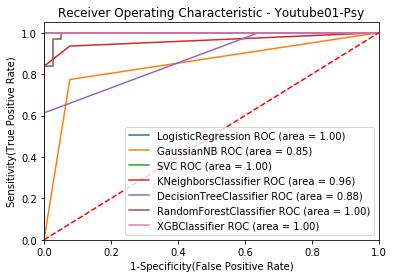

PROCESSING DATASET......... Youtube02-KatyPerry

                              COMMENT_ID        AUTHOR                 DATE  \
0      z12pgdhovmrktzm3i23es5d5junftft3f   lekanaVEVO1  2014-07-22T15:27:50   
1    z13yx345uxepetggz04ci5rjcxeohzlrtf4      Pyunghee  2014-07-27T01:57:16   
2  z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k    Erica Ross  2014-07-27T02:51:43   
3    z13jcjuovxbwfr0ge04cev2ipsjdfdurwck  Aviel Haimov  2014-08-01T12:27:48   
4  z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k    John Bello  2014-08-01T21:04:03   

                                             CONTENT  CLASS  
0  i love this so much. AND also I Generate Free ...      1  
1  http://www.billboard.com/articles/columns/pop-...      1  
2  Hey guys! Please join me in my fight to help a...      1  
3  http://psnboss.com/?ref=2tGgp3pV6L this is the...      1  
4  Hey everyone. Watch this trailer!!!!!!!!  http...      1  
APPLYING NLP ON ......... Youtube02-KatyPerry

SPLITTING INTO TRAIN AND TEST......... Youtube02-KatyPerr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 10, 'penalty': 'l1'}


Training   accuracy  :  91.74 % (+/-) 0.51 %
Validation   accuracy  :  88.36 % (+/-) 3.34 %


Training   roc_auc  :  94.09 % (+/-) 0.19 %
Validation   roc_auc  :  92.41 % (+/-) 2.32 %


Training   precision_macro  :  89.51 % (+/-) 0.43 %
Validation   precision_macro  :  86.53 % (+/-) 3.0 %


Training   recall_micro  :  91.74 % (+/-) 0.51 %
Validation   recall_micro  :  88.36 % (+/-) 3.34 %


Training   f1_micro  :  91.74 % (+/-) 0.51 %
Validation   f1_micro  :  88.36 % (+/-) 3.34 %


-----------------------------------------


 Optimized  Naive- Bayes Classifier for  Youtube02-KatyPerry
---------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {}


Training   accuracy  :  98.81 % (+/-) 0.5 %
Validation   accuracy  :  85.36 % (+/-) 8.1 %


Training   roc_auc  :  98.83 % (+/-) 0.5 %
Validation   roc_auc  :  85.36 % (+/-) 8.08 %


Training   precision_macro  :  98.83 % (+/-) 0.49 %
Validation   precision_macro  :  85.65 % (+/-) 8.14 %


Training   recall_micro  :  98.81 % (+/-) 0.5 %
Validation   recall_micro  :  85.36 % (+/-) 8.1 %


Training   f1_micro  :  98.81 % (+/-) 0.5 %
Validation   f1_micro  :  85.36 % (+/-) 8.1 %


-----------------------------------------


 Optimized  Support Vector Classifier for  Youtube02-KatyPerry
---------------------------------------
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.5, 'kernel': 'linear'}


Training   accuracy  :  63.04 % (+/-) 0.07 %
Validation   accuracy  :  61.65 % (+/-) 1.72 %


Training   roc_auc  :  99.51 % (+/-) 0.17 %
Validation   roc_auc  :  96.03 % (+/-) 3.19 %


Training   precision_macro  :  44.02 % (+/-) 0.04 %
Validation   precision_macro  :  42.7 % (+/-) 1.35 %


Training   recall_micro  :  63.04 % (+/-) 0.07 %
Validation   recall_micro  :  61.65 % (+/-) 1.72 %


Training   f1_micro  :  63.04 % (+/-) 0.07 %
Validation   f1_micro  :  61.65 % (+/-) 1.72 %


-----------------------------------------


 Optimized  K-Nearest Neighbor for  Youtube02-KatyPerry
---------------------------------------
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 3}


Training   accuracy  :  86.23 % (+/-) 0.76 %
Validation   accuracy  :  82.17 % (+/-) 6.31 %


Training   roc_auc  :  99.33 % (+/-) 0.22 %
Validation   roc_auc  :  91.14 % (+/-) 4.78 %


Training   precision_macro  :  89.04 % (+/-) 0.49 %
Validation   precision_macro  :  86.92 % (+/-) 3.42 %


Training   recall_micro  :  86.23 % (+/-) 0.76 %
Validation   recall_micro  :  82.17 % (+/-) 6.31 %


Training   f1_micro  :  86.23 % (+/-) 0.76 %
Validation   f1_micro  :  82.17 % (+/-) 6.31 %


-----------------------------------------


 Optimized  Decision Tree Classifier for  Youtube02-KatyPerry
---------------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}


Training   accuracy  :  84.77 % (+/-) 0.65 %
Validation   accuracy  :  80.31 % (+/-) 4.66 %


Training   roc_auc  :  85.2 % (+/-) 0.66 %
Validation   roc_auc  :  80.58 % (+/-) 4.49 %


Training   precision_macro  :  87.96 % (+/-) 0.44 %
Validation   precision_macro  :  85.27 % (+/-) 2.73 %


Training   recall_micro  :  84.77 % (+/-) 0.65 %
Validation   recall_micro  :  80.31 % (+/-) 4.66 %


Training   f1_micro  :  84.77 % (+/-) 0.65 %
Validation   f1_micro  :  80.31 % (+/-) 4.66 %


-----------------------------------------


 Optimized  Random Forest Classifier for  Youtube02-KatyPerry
---------------------------------------
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.1min finished




Best Parameters:  {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 500}


Training   accuracy  :  88.88 % (+/-) 2.68 %
Validation   accuracy  :  87.49 % (+/-) 3.64 %


Training   roc_auc  :  94.4 % (+/-) 1.96 %
Validation   roc_auc  :  93.19 % (+/-) 3.14 %


Training   precision_macro  :  90.33 % (+/-) 2.09 %
Validation   precision_macro  :  89.28 % (+/-) 2.95 %


Training   recall_micro  :  88.88 % (+/-) 2.68 %
Validation   recall_micro  :  87.49 % (+/-) 3.64 %


Training   f1_micro  :  88.88 % (+/-) 2.68 %
Validation   f1_micro  :  87.49 % (+/-) 3.64 %


-----------------------------------------


 Optimized  XGBoost Classifier for  Youtube02-KatyPerry
---------------------------------------
Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.7min finished




Best Parameters:  {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 1.0}


Training   accuracy  :  91.32 % (+/-) 1.29 %
Validation   accuracy  :  87.39 % (+/-) 1.22 %


Training   roc_auc  :  96.45 % (+/-) 0.45 %
Validation   roc_auc  :  94.46 % (+/-) 0.9 %


Training   precision_macro  :  92.42 % (+/-) 1.05 %
Validation   precision_macro  :  88.9 % (+/-) 1.14 %


Training   recall_micro  :  91.32 % (+/-) 1.29 %
Validation   recall_micro  :  87.39 % (+/-) 1.22 %


Training   f1_micro  :  91.32 % (+/-) 1.29 %
Validation   f1_micro  :  87.39 % (+/-) 1.22 %


-----------------------------------------
Comparing the Best Cross-Validated Accuracy between Classifiers
FITTING THE BEST CLASSIFIER AND PREDICTING TEST SET RESULT FOR  Youtube02-KatyPerry

Validation Scores:

Predicting test data for  Youtube02-KatyPerry : Using  LogisticRegression


Precision:
Training score:  100.0 % 	 Testing score:  96.97 %
Recall:
Training score:

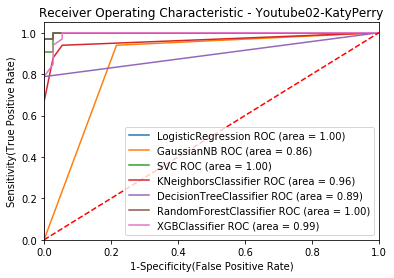

PROCESSING DATASET......... Youtube05-Shakira

                              COMMENT_ID                              AUTHOR  \
0    z13lgffb5w3ddx1ul22qy1wxspy5cpkz504                          dharma pal   
1      z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj                       Tiza Arellano   
2  z12quxxp2vutflkxv04cihggzt2azl34pms0k  Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿   
3      z12icv3ysqvlwth2c23eddlykyqut5z1h                       Eric Gonzalez   
4      z133stly3kete3tly22petvwdpmghrlli                       Analena López   

                         DATE  \
0  2015-05-29T02:30:18.971000   
1  2015-05-29T00:14:48.748000   
2  2015-05-28T21:00:08.607000   
3  2015-05-28T20:47:12.193000   
4  2015-05-28T17:08:29.827000   

                                             CONTENT  CLASS  
0                                         Nice song﻿      0  
1                                      I love song ﻿      0  
2                                      I love song ﻿      0  
3  860,000,000 lets make 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.1, 'penalty': 'l2'}


Training   accuracy  :  92.68 % (+/-) 0.38 %
Validation   accuracy  :  89.86 % (+/-) 3.48 %


Training   roc_auc  :  94.24 % (+/-) 0.12 %
Validation   roc_auc  :  92.88 % (+/-) 2.31 %


Training   precision_macro  :  90.42 % (+/-) 0.31 %
Validation   precision_macro  :  88.15 % (+/-) 2.74 %


Training   recall_micro  :  92.68 % (+/-) 0.38 %
Validation   recall_micro  :  89.86 % (+/-) 3.48 %


Training   f1_micro  :  92.68 % (+/-) 0.38 %
Validation   f1_micro  :  89.86 % (+/-) 3.48 %


-----------------------------------------


 Optimized  Naive- Bayes Classifier for  Youtube05-Shakira
---------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {}


Training   accuracy  :  99.66 % (+/-) 0.11 %
Validation   accuracy  :  89.53 % (+/-) 4.98 %


Training   roc_auc  :  99.66 % (+/-) 0.11 %
Validation   roc_auc  :  89.64 % (+/-) 4.83 %


Training   precision_macro  :  99.67 % (+/-) 0.11 %
Validation   precision_macro  :  90.66 % (+/-) 4.02 %


Training   recall_micro  :  99.66 % (+/-) 0.11 %
Validation   recall_micro  :  89.53 % (+/-) 4.98 %


Training   f1_micro  :  99.66 % (+/-) 0.11 %
Validation   f1_micro  :  89.53 % (+/-) 4.98 %


-----------------------------------------


 Optimized  Support Vector Classifier for  Youtube05-Shakira
---------------------------------------
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.5, 'kernel': 'linear'}


Training   accuracy  :  64.88 % (+/-) 0.47 %
Validation   accuracy  :  63.37 % (+/-) 2.36 %


Training   roc_auc  :  99.3 % (+/-) 0.14 %
Validation   roc_auc  :  98.05 % (+/-) 2.54 %


Training   precision_macro  :  73.83 % (+/-) 3.02 %
Validation   precision_macro  :  55.59 % (+/-) 11.71 %


Training   recall_micro  :  64.88 % (+/-) 0.47 %
Validation   recall_micro  :  63.37 % (+/-) 2.36 %


Training   f1_micro  :  64.88 % (+/-) 0.47 %
Validation   f1_micro  :  63.37 % (+/-) 2.36 %


-----------------------------------------


 Optimized  K-Nearest Neighbor for  Youtube05-Shakira
---------------------------------------
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'algorithm': 'auto', 'n_neighbors': 3}


Training   accuracy  :  90.12 % (+/-) 1.17 %
Validation   accuracy  :  83.98 % (+/-) 6.82 %


Training   roc_auc  :  99.19 % (+/-) 0.22 %
Validation   roc_auc  :  92.87 % (+/-) 4.72 %


Training   precision_macro  :  91.84 % (+/-) 0.83 %
Validation   precision_macro  :  88.18 % (+/-) 4.47 %


Training   recall_micro  :  90.12 % (+/-) 1.17 %
Validation   recall_micro  :  83.98 % (+/-) 6.82 %


Training   f1_micro  :  90.12 % (+/-) 1.17 %
Validation   f1_micro  :  83.98 % (+/-) 6.82 %


-----------------------------------------


 Optimized  Decision Tree Classifier for  Youtube05-Shakira
---------------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}


Training   accuracy  :  85.81 % (+/-) 0.64 %
Validation   accuracy  :  85.81 % (+/-) 5.75 %


Training   roc_auc  :  85.62 % (+/-) 0.65 %
Validation   roc_auc  :  85.59 % (+/-) 5.88 %


Training   precision_macro  :  89.15 % (+/-) 0.38 %
Validation   precision_macro  :  89.46 % (+/-) 3.46 %


Training   recall_micro  :  85.81 % (+/-) 0.64 %
Validation   recall_micro  :  85.81 % (+/-) 5.75 %


Training   f1_micro  :  85.81 % (+/-) 0.64 %
Validation   f1_micro  :  85.81 % (+/-) 5.75 %


-----------------------------------------


 Optimized  Random Forest Classifier for  Youtube05-Shakira
---------------------------------------
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.1min finished




Best Parameters:  {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 500}


Training   accuracy  :  83.63 % (+/-) 3.22 %
Validation   accuracy  :  81.12 % (+/-) 6.55 %


Training   roc_auc  :  95.58 % (+/-) 1.48 %
Validation   roc_auc  :  94.26 % (+/-) 2.7 %


Training   precision_macro  :  87.67 % (+/-) 1.98 %
Validation   precision_macro  :  86.37 % (+/-) 3.75 %


Training   recall_micro  :  83.63 % (+/-) 3.22 %
Validation   recall_micro  :  81.12 % (+/-) 6.55 %


Training   f1_micro  :  83.63 % (+/-) 3.22 %
Validation   f1_micro  :  81.12 % (+/-) 6.55 %


-----------------------------------------


 Optimized  XGBoost Classifier for  Youtube05-Shakira
---------------------------------------
Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.0min finished




Best Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 1.0}


Training   accuracy  :  90.1 % (+/-) 0.84 %
Validation   accuracy  :  87.81 % (+/-) 1.79 %


Training   roc_auc  :  97.32 % (+/-) 0.41 %
Validation   roc_auc  :  94.36 % (+/-) 0.64 %


Training   precision_macro  :  91.89 % (+/-) 0.56 %
Validation   precision_macro  :  90.38 % (+/-) 1.13 %


Training   recall_micro  :  90.1 % (+/-) 0.84 %
Validation   recall_micro  :  87.81 % (+/-) 1.79 %


Training   f1_micro  :  90.1 % (+/-) 0.84 %
Validation   f1_micro  :  87.81 % (+/-) 1.79 %


-----------------------------------------
Comparing the Best Cross-Validated Accuracy between Classifiers
FITTING THE BEST CLASSIFIER AND PREDICTING TEST SET RESULT FOR  Youtube05-Shakira

Validation Scores:

Predicting test data for  Youtube05-Shakira : Using  LogisticRegression


Precision:
Training score:  95.21 % 	 Testing score:  71.43 %
Recall:
Training score:  99.

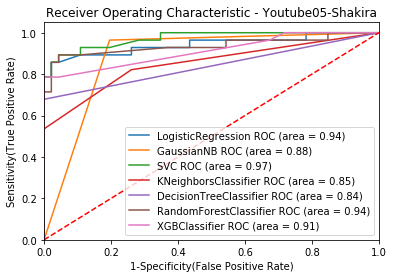

PROCESSING DATASET......... Youtube04-Eminem

                            COMMENT_ID         AUTHOR  \
0    z12rwfnyyrbsefonb232i5ehdxzkjzjs2    Lisa Wellas   
1  z130wpnwwnyuetxcn23xf5k5ynmkdpjrj04   jason graham   
2    z13vsfqirtavjvu0t22ezrgzyorwxhpf3     Ajkal Khan   
3  z12wjzc4eprnvja4304cgbbizuved35wxcs  Dakota Taylor   
4    z13xjfr42z3uxdz2223gx5rrzs3dt5hna    Jihad Naser   

                         DATE  \
0                         NaN   
1  2015-05-29T02:26:10.652000   
2                         NaN   
3  2015-05-29T02:13:07.810000   
4                         NaN   

                                             CONTENT  CLASS  
0          +447935454150 lovely girl talk to me xxx﻿      1  
1    I always end up coming back to this song<br />﻿      0  
2  "my sister just received over 6,500 new <a rel...      1  
3                                              Cool﻿      0  
4                     Hello I&#39;am from Palastine﻿      1  
APPLYING NLP ON ......... Youtube04-Emin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.5, 'penalty': 'l1'}


Training   accuracy  :  92.8 % (+/-) 0.25 %
Validation   accuracy  :  91.37 % (+/-) 2.83 %


Training   roc_auc  :  94.37 % (+/-) 0.21 %
Validation   roc_auc  :  93.2 % (+/-) 2.11 %


Training   precision_macro  :  90.46 % (+/-) 0.24 %
Validation   precision_macro  :  89.21 % (+/-) 2.53 %


Training   recall_micro  :  92.8 % (+/-) 0.25 %
Validation   recall_micro  :  91.37 % (+/-) 2.83 %


Training   f1_micro  :  92.8 % (+/-) 0.25 %
Validation   f1_micro  :  91.37 % (+/-) 2.83 %


-----------------------------------------


 Optimized  Naive- Bayes Classifier for  Youtube04-Eminem
---------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {}


Training   accuracy  :  100.0 % (+/-) 0.0 %
Validation   accuracy  :  87.68 % (+/-) 4.53 %


Training   roc_auc  :  100.0 % (+/-) 0.0 %
Validation   roc_auc  :  87.21 % (+/-) 4.67 %


Training   precision_macro  :  100.0 % (+/-) 0.0 %
Validation   precision_macro  :  89.52 % (+/-) 4.01 %


Training   recall_micro  :  100.0 % (+/-) 0.0 %
Validation   recall_micro  :  87.68 % (+/-) 4.53 %


Training   f1_micro  :  100.0 % (+/-) 0.0 %
Validation   f1_micro  :  87.68 % (+/-) 4.53 %


-----------------------------------------


 Optimized  Support Vector Classifier for  Youtube04-Eminem
---------------------------------------
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.5, 'kernel': 'linear'}


Training   accuracy  :  64.23 % (+/-) 0.09 %
Validation   accuracy  :  63.39 % (+/-) 1.22 %


Training   roc_auc  :  99.28 % (+/-) 0.16 %
Validation   roc_auc  :  97.64 % (+/-) 2.92 %


Training   precision_macro  :  45.2 % (+/-) 1.3 %
Validation   precision_macro  :  44.09 % (+/-) 1.86 %


Training   recall_micro  :  64.23 % (+/-) 0.09 %
Validation   recall_micro  :  63.39 % (+/-) 1.22 %


Training   f1_micro  :  64.23 % (+/-) 0.09 %
Validation   f1_micro  :  63.39 % (+/-) 1.22 %


-----------------------------------------


 Optimized  K-Nearest Neighbor for  Youtube04-Eminem
---------------------------------------
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 3}


Training   accuracy  :  87.58 % (+/-) 1.17 %
Validation   accuracy  :  81.16 % (+/-) 6.0 %


Training   roc_auc  :  99.76 % (+/-) 0.07 %
Validation   roc_auc  :  92.7 % (+/-) 4.64 %


Training   precision_macro  :  89.78 % (+/-) 0.77 %
Validation   precision_macro  :  85.9 % (+/-) 3.73 %


Training   recall_micro  :  87.58 % (+/-) 1.17 %
Validation   recall_micro  :  81.16 % (+/-) 6.0 %


Training   f1_micro  :  87.58 % (+/-) 1.17 %
Validation   f1_micro  :  81.16 % (+/-) 6.0 %


-----------------------------------------


 Optimized  Decision Tree Classifier for  Youtube04-Eminem
---------------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}


Training   accuracy  :  95.38 % (+/-) 0.36 %
Validation   accuracy  :  95.38 % (+/-) 3.25 %


Training   roc_auc  :  95.59 % (+/-) 0.34 %
Validation   roc_auc  :  95.6 % (+/-) 3.07 %


Training   precision_macro  :  95.63 % (+/-) 0.32 %
Validation   precision_macro  :  95.79 % (+/-) 2.76 %


Training   recall_micro  :  95.38 % (+/-) 0.36 %
Validation   recall_micro  :  95.38 % (+/-) 3.25 %


Training   f1_micro  :  95.38 % (+/-) 0.36 %
Validation   f1_micro  :  95.38 % (+/-) 3.25 %


-----------------------------------------


 Optimized  Random Forest Classifier for  Youtube04-Eminem
---------------------------------------
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.2min finished




Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 300}


Training   accuracy  :  91.62 % (+/-) 2.9 %
Validation   accuracy  :  89.85 % (+/-) 5.14 %


Training   roc_auc  :  96.24 % (+/-) 1.51 %
Validation   roc_auc  :  95.12 % (+/-) 2.93 %


Training   precision_macro  :  92.17 % (+/-) 2.57 %
Validation   precision_macro  :  90.64 % (+/-) 4.8 %


Training   recall_micro  :  91.62 % (+/-) 2.9 %
Validation   recall_micro  :  89.85 % (+/-) 5.14 %


Training   f1_micro  :  91.62 % (+/-) 2.9 %
Validation   f1_micro  :  89.85 % (+/-) 5.14 %


-----------------------------------------


 Optimized  XGBoost Classifier for  Youtube04-Eminem
---------------------------------------
Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.7min finished




Best Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.6}


Training   accuracy  :  95.15 % (+/-) 1.22 %
Validation   accuracy  :  93.98 % (+/-) 2.92 %


Training   roc_auc  :  98.63 % (+/-) 0.23 %
Validation   roc_auc  :  96.39 % (+/-) 1.88 %


Training   precision_macro  :  95.44 % (+/-) 1.02 %
Validation   precision_macro  :  94.52 % (+/-) 2.45 %


Training   recall_micro  :  95.15 % (+/-) 1.22 %
Validation   recall_micro  :  93.98 % (+/-) 2.92 %


Training   f1_micro  :  95.15 % (+/-) 1.22 %
Validation   f1_micro  :  93.98 % (+/-) 2.92 %


-----------------------------------------
Comparing the Best Cross-Validated Accuracy between Classifiers
FITTING THE BEST CLASSIFIER AND PREDICTING TEST SET RESULT FOR  Youtube04-Eminem

Validation Scores:

Predicting test data for  Youtube04-Eminem : Using  LogisticRegression


Precision:
Training score:  95.72 % 	 Testing score:  89.47 %
Recall:
Training score:  10

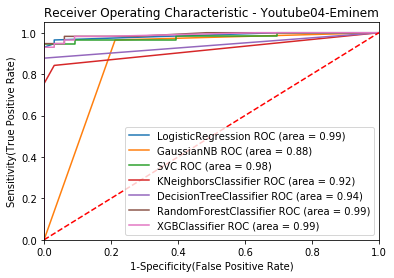

PROCESSING DATASET......... Youtube03-LMFAO

                              COMMENT_ID        AUTHOR  \
0  z13uwn2heqndtr5g304ccv5j5kqqzxjadmc0k  Corey Wilson   
1  z124jvczaz3dxhnbc04cffk43oiugj25yzo0k   Epic Gaming   
2      z13tczjy5xj0vjmu5231unho1ofey5zdk     LaS Music   
3  z13tzr0hdpnayhqqc04cd3zqqqjkf3ngckk0k    Cheryl Fox   
4  z12pcvix4zedcjvyb04ccr1r0mr2g5xwyng0k    PATRICK_TW   

                         DATE  \
0  2015-05-28T21:39:52.376000   
1  2015-05-28T20:07:20.610000   
2  2015-05-28T19:23:35.355000   
3  2015-05-28T17:49:35.294000   
4  2015-05-28T16:28:26.818000   

                                             CONTENT  CLASS  
0  "<a href=""http://www.youtube.com/watch?v=KQ6z...      0  
1                                   wierd but funny﻿      0  
2  "Hey guys, I&#39;m a human.<br /><br /><br />B...      1  
3       Party Rock....lol...who wants to shuffle!!!﻿      0  
4                                        Party rock﻿      0  
APPLYING NLP ON ......... Youtube03

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 10, 'penalty': 'l1'}


Training   accuracy  :  91.98 % (+/-) 0.24 %
Validation   accuracy  :  89.91 % (+/-) 2.55 %


Training   roc_auc  :  94.05 % (+/-) 0.1 %
Validation   roc_auc  :  93.19 % (+/-) 1.57 %


Training   precision_macro  :  89.7 % (+/-) 0.23 %
Validation   precision_macro  :  87.79 % (+/-) 2.35 %


Training   recall_micro  :  91.98 % (+/-) 0.24 %
Validation   recall_micro  :  89.91 % (+/-) 2.55 %


Training   f1_micro  :  91.98 % (+/-) 0.24 %
Validation   f1_micro  :  89.91 % (+/-) 2.55 %


-----------------------------------------


 Optimized  Naive- Bayes Classifier for  Youtube03-LMFAO
---------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {}


Training   accuracy  :  99.71 % (+/-) 0.1 %
Validation   accuracy  :  92.0 % (+/-) 3.57 %


Training   roc_auc  :  99.74 % (+/-) 0.09 %
Validation   roc_auc  :  92.04 % (+/-) 3.5 %


Training   precision_macro  :  99.69 % (+/-) 0.1 %
Validation   precision_macro  :  92.64 % (+/-) 3.44 %


Training   recall_micro  :  99.71 % (+/-) 0.1 %
Validation   recall_micro  :  92.0 % (+/-) 3.57 %


Training   f1_micro  :  99.71 % (+/-) 0.1 %
Validation   f1_micro  :  92.0 % (+/-) 3.57 %


-----------------------------------------


 Optimized  Support Vector Classifier for  Youtube03-LMFAO
---------------------------------------
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'C': 0.9, 'kernel': 'linear'}


Training   accuracy  :  65.71 % (+/-) 0.0 %
Validation   accuracy  :  64.79 % (+/-) 0.62 %


Training   roc_auc  :  97.71 % (+/-) 0.42 %
Validation   roc_auc  :  95.62 % (+/-) 3.24 %


Training   precision_macro  :  45.36 % (+/-) 0.0 %
Validation   precision_macro  :  44.44 % (+/-) 0.58 %


Training   recall_micro  :  65.71 % (+/-) 0.0 %
Validation   recall_micro  :  64.79 % (+/-) 0.62 %


Training   f1_micro  :  65.71 % (+/-) 0.0 %
Validation   f1_micro  :  64.79 % (+/-) 0.62 %


-----------------------------------------


 Optimized  K-Nearest Neighbor for  Youtube03-LMFAO
---------------------------------------
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 3}


Training   accuracy  :  94.07 % (+/-) 0.42 %
Validation   accuracy  :  92.02 % (+/-) 3.38 %


Training   roc_auc  :  99.71 % (+/-) 0.06 %
Validation   roc_auc  :  95.06 % (+/-) 2.91 %


Training   precision_macro  :  94.16 % (+/-) 0.38 %
Validation   precision_macro  :  92.49 % (+/-) 3.06 %


Training   recall_micro  :  94.07 % (+/-) 0.42 %
Validation   recall_micro  :  92.02 % (+/-) 3.38 %


Training   f1_micro  :  94.07 % (+/-) 0.42 %
Validation   f1_micro  :  92.02 % (+/-) 3.38 %


-----------------------------------------


 Optimized  Decision Tree Classifier for  Youtube03-LMFAO
---------------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}


Training   accuracy  :  93.43 % (+/-) 0.41 %
Validation   accuracy  :  93.43 % (+/-) 3.69 %


Training   roc_auc  :  94.06 % (+/-) 0.37 %
Validation   roc_auc  :  93.92 % (+/-) 3.43 %


Training   precision_macro  :  93.74 % (+/-) 0.35 %
Validation   precision_macro  :  93.94 % (+/-) 3.09 %


Training   recall_micro  :  93.43 % (+/-) 0.41 %
Validation   recall_micro  :  93.43 % (+/-) 3.69 %


Training   f1_micro  :  93.43 % (+/-) 0.41 %
Validation   f1_micro  :  93.43 % (+/-) 3.69 %


-----------------------------------------


 Optimized  Random Forest Classifier for  Youtube03-LMFAO
---------------------------------------
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}


Training   accuracy  :  81.88 % (+/-) 6.26 %
Validation   accuracy  :  80.92 % (+/-) 7.14 %


Training   roc_auc  :  95.86 % (+/-) 1.52 %
Validation   roc_auc  :  95.31 % (+/-) 2.09 %


Training   precision_macro  :  86.15 % (+/-) 4.46 %
Validation   precision_macro  :  85.52 % (+/-) 5.12 %


Training   recall_micro  :  81.88 % (+/-) 6.26 %
Validation   recall_micro  :  80.92 % (+/-) 7.14 %


Training   f1_micro  :  81.88 % (+/-) 6.26 %
Validation   f1_micro  :  80.92 % (+/-) 7.14 %


-----------------------------------------


 Optimized  XGBoost Classifier for  Youtube03-LMFAO
---------------------------------------
Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  1.5min finished




Best Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}


Training   accuracy  :  93.74 % (+/-) 1.52 %
Validation   accuracy  :  93.52 % (+/-) 2.01 %


Training   roc_auc  :  97.64 % (+/-) 0.94 %
Validation   roc_auc  :  97.38 % (+/-) 1.19 %


Training   precision_macro  :  94.04 % (+/-) 1.31 %
Validation   precision_macro  :  93.87 % (+/-) 1.71 %


Training   recall_micro  :  93.74 % (+/-) 1.52 %
Validation   recall_micro  :  93.52 % (+/-) 2.01 %


Training   f1_micro  :  93.74 % (+/-) 1.52 %
Validation   f1_micro  :  93.52 % (+/-) 2.01 %


-----------------------------------------
Comparing the Best Cross-Validated Accuracy between Classifiers
FITTING THE BEST CLASSIFIER AND PREDICTING TEST SET RESULT FOR  Youtube03-LMFAO

Validation Scores:

Predicting test data for  Youtube03-LMFAO : Using  LogisticRegression


Precision:
Training score:  100.0 % 	 Testing score:  95.65 %
Recall:
Training score:  100.

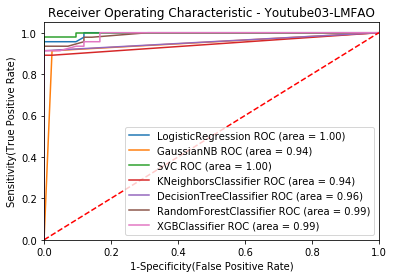

In [12]:
# Data Input
base_dir = '../input/'
data_files = [os.path.join(base_dir,f) for f in os.listdir(base_dir)] 
files = os.listdir(base_dir)
input_dir = './ directory'

df = pd.DataFrame()
df_all = pd.DataFrame()
df_list =[]
for csv_file,file in zip(data_files, files):
    filename, file_extension = os.path.splitext(file)
    tsv_file = input_dir+ filename + '_input.tsv'
    
    print('PROCESSING DATASET.........', filename)
    print('===========================================================\n')
        
    #convert csv files to tsv format
    input_file = convert_to_tsv(csv_file, tsv_file)
    
    if filename == 'Youtube04-Eminem':
        dataset = pd.read_csv(input_file,delimiter = '\t', skiprows = range(270,276), quoting = 3)
        #skipping content with nan values
    else:
        #Reading the tsvfile ignoring quotes
        dataset = pd.read_csv(input_file,delimiter = '\t', quoting = 3)
    #Viewing the columns
    print(dataset.head())

# APPLYING NLP
    print('APPLYING NLP ON .........', filename)
    print('===========================================================\n')
       
    #Cleaning texts 
    corpus = create_corpus(dataset)
    
    X,y = bag_of_words(corpus)

# DATA PRE-PROCESSING FOR CLASSIFICATION
    # Splitting the dataset into the Training set and Test set
    print('SPLITTING INTO TRAIN AND TEST.........', filename)
    print('===========================================================\n')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
# OPTIMIZING PARAMETERS FOR CLASSIFIERS
    #Find the best hyper parameters using GridSearchCV method
    print('OPTIMIZATION OF CLASSIFIERS THROUGH GRIDSEARCHCV FOR ', filename)
    print('===========================================================\n')
       
    best_estimators = best_estimator(classifiers, X_train, y_train, filename)

# FIT & PREDICT DATA TO THE BEST VERSION OF CLASSIFIERS
    #Simple fit_predict to see how each classifier performs
    print('FITTING THE BEST CLASSIFIER AND PREDICTING TEST SET RESULT FOR ', filename)
    print('===========================================================\n')
       
    y_preds = simple_fit_predict(classifiers,best_estimators, X_train, X_test, y_train, y_test, filename)
        
# EVALUATING CLASSIFIERS
    
  
    #SPAM DETECTION PERFORMANCE COMPARISON OF CLASSIFIERS
    print('PERFORMANCE COMPARISON OF CLASSIFIERS FOR ', filename)
    print('===========================================================\n')
       
    df = performance_comparison(best_estimators, y_preds, y_test, filename)
    print(df.head(8))
    
    df_list.append(df)
    print('===========================================================')
    
    #Plot ROC curves
    roc_curves(classifiers, best_estimators, X_test, y_test, filename)    

df_all = pd.concat(df_list, ignore_index = True)
    

In [13]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [14]:
from tabulate import tabulate
print('======================================\n')
print('FINAL PERFORMANCE COMPARISON GRID\n')
print('======================================\n')
headers = ['Classifier','Accuracy','Spam Caught','Blocked Ham','Mathews Coeff','F1 Score']
[print("Dataset Name: ",f,"\n\n",tabulate(x, headers = headers, tablefmt='psql', numalign="right",floatfmt=".2f"),"\n\n") for f,x in zip(files,df_list)]


FINAL PERFORMANCE COMPARISON GRID


Dataset Name:  Youtube01-Psy.csv 

 +----+------------------------+------------+---------------+---------------+-----------------+------------+
|    | Classifier             |   Accuracy |   Spam Caught |   Blocked Ham |   Mathews Coeff |   F1 Score |
|----+------------------------+------------+---------------+---------------+-----------------+------------|
|  0 | LogisticRegression     |      98.57 |         96.88 |          0.00 |           97.16 |      98.42 |
|  1 | GaussianNB             |      85.71 |         88.89 |         16.28 |           71.15 |      82.76 |
|  2 | SVC                    |      98.57 |        100.00 |          2.50 |           97.14 |      98.36 |
|  3 | KNeighborsClassifier   |      92.86 |        100.00 |         11.36 |           86.22 |      91.23 |
|  4 | DecisionTreeClassifier |      81.43 |        100.00 |         25.00 |           65.99 |      73.47 |
|  5 | RandomForestClassifier |      78.57 |         67.39 |   

[None, None, None, None, None]

### Evaluation and Conclusion

- Performance on Youtube01-Psy: XGBoost Classifier performed the best for all metrics, followed by SVC and Logistic Regression. Three classifiers (Random Forest, SVC and XGBoost were able to bring the Blocked Ham to 0%.

- Performance on Youtube02-KatyPerry: Both SVC and Logistic Regression performed the best for all evaluation metrics, including Blocked Ham and Matthew's Coefficient. But 

- Performance on Youtube03-LMFAO: Logistic Regression stood out by performing the best across all metrics, followed by SVC and Random Forest.

- Performance on Youtube04-Eminem: Logistic Regression performed the best in terms of accuracy, followed equally by SVC, Decision Tree and XGBoost. But all of them suffered with higher Blocked Ham. Gaussian Naive Bayes seem to have less Blocked Ham, but it had 2 points lesser accuracy.

- Performance on Youtube05-Shakira: For this data, no one classifier performed the best. Gaussian Naive Bayes had the lowest Blocked Ham, but it sacrificed Matthews Coefficient and Spam Caught rate. Here, comparitively SVC did the best overall, even though it had 11.54% Blocked Ham.

###### Overall, Logisitic Regression was the best classifier considering all datasets.

End of Program